In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Ventes.csv")
data = data[:-1]
data.columns=["Date","Sales"]
data.asfreq("MS")

,Date,Sales
1970-01-01,NaN,NaN


In [3]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
# 1. S'assurer que les dates sont continues et sans doublons
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').drop_duplicates('Date')
# 2. Mettre Date en index et forcer la fréquence trimestrielle
data.set_index('Date', inplace=True)
#3- Traitement des valeurs manquantes
first_valid = data.first_valid_index()      # repère la 1ʳᵉ date non-NaN
data = data.loc[first_valid:]          # coupe tout ce qui précède
data = data.interpolate(method = "linear", axis = 0, limit_direction= "both")

In [4]:
split_index = int(len(data) * 0.90)
train_set = data.iloc[:split_index]
test_set = data.iloc[split_index:]

In [5]:
train_set

,Sales
Date,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1971-07-01,4633.0
1971-08-01,1659.0
1971-09-01,5951.0


In [6]:
test_set

,Sales
Date,
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0


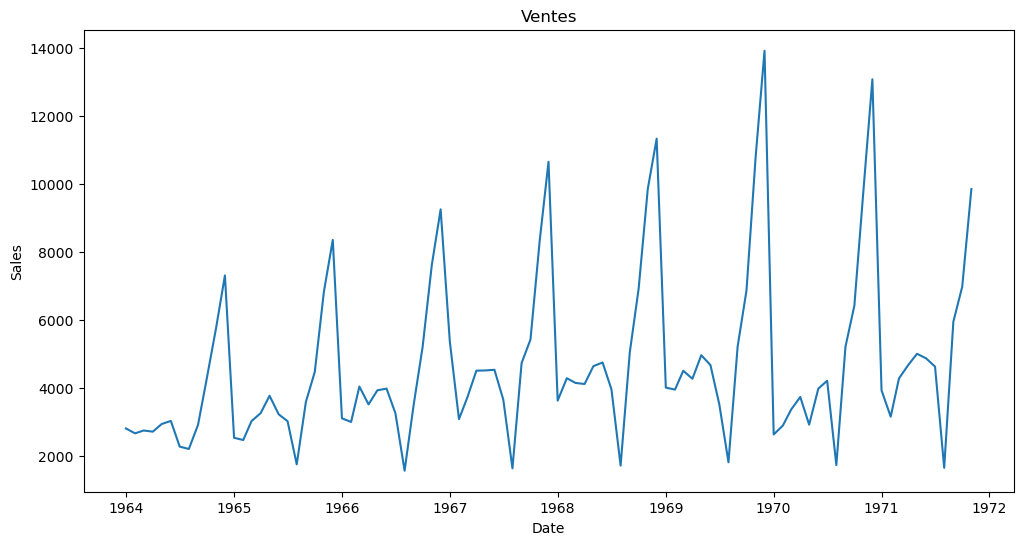

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = train_set, x = 'Date', y= 'Sales')
plt.title("Ventes")
plt.show()


In [8]:
#test dickey fuller sur la serie :

resultat_adf = adfuller(train_set)
print("Statistique ADF :", resultat_adf[0])
print("P-value :", resultat_adf[1])
print("Valeurs critiques :", resultat_adf[4])

Statistique ADF : -1.4943866247492292
P-value : 0.5362863451889428
Valeurs critiques : {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}


In [9]:
#differenciation:
serie_diff = train_set.diff()
serie_diff = serie_diff.dropna()

<Axes: xlabel='Date'>

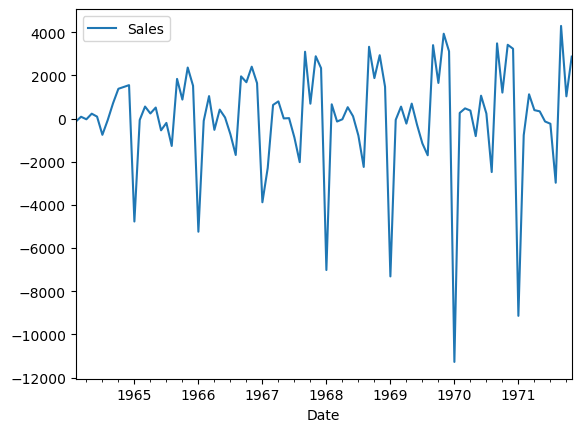

In [10]:
serie_diff.plot()

In [11]:
#test dickey fuller
resultat_adf = adfuller(serie_diff)
print("Statistique ADF :", resultat_adf[0])
print("P-value :", resultat_adf[1])
print("Valeurs critiques :", resultat_adf[4])

Statistique ADF : -24.664513810945362
P-value : 0.0
Valeurs critiques : {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}


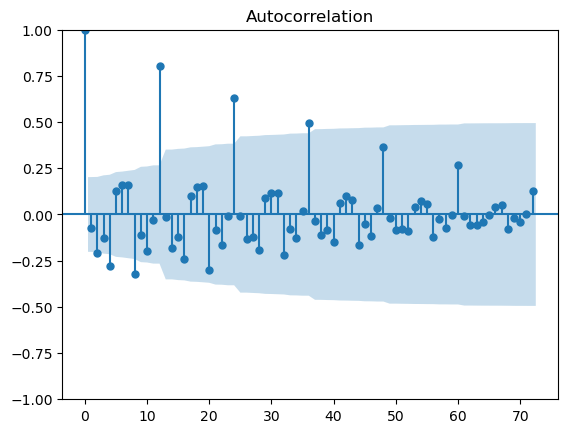

In [12]:
plot_acf(serie_diff, lags = 72)
plt.show()

Bande bleue = test de bartlett :
### 📏 Intervalle de confiance du test de Bartlett

L'intervalle de confiance au seuil de 5% est donné par :

$$
\left[ -\frac{z_{\alpha/2}}{\sqrt{T}} \ , \ \frac{z_{\alpha/2}}{\sqrt{T}} \right]
$$




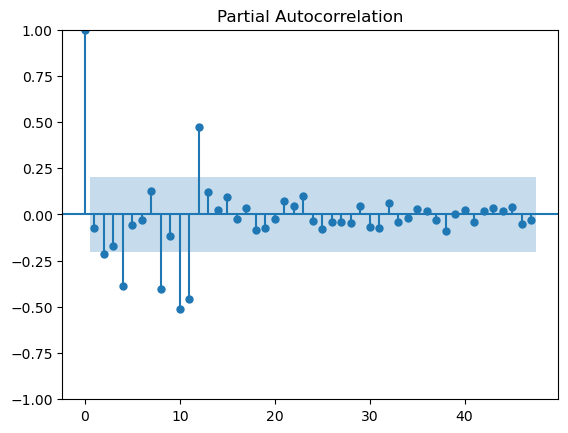

In [13]:
plot_pacf(serie_diff, lags = 47)
plt.show()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(train_set, order=(1,1,1), seasonal_order = (1,1,0,12))
res   = model.fit()
print(res.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   95
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -661.731
Date:                             Sat, 24 May 2025   AIC                           1331.462
Time:                                     21:03:12   BIC                           1341.089
Sample:                                 01-01-1964   HQIC                          1335.327
                                      - 11-01-1971                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2932      0.077      3.817      0.000       0.143       0.444
ma.L1         -0.9432      

In [15]:
model = SARIMAX(train_set, order = (1,1,0), seasonal_order = (1,1,0,12))
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -671.905
Date:                            Sat, 24 May 2025   AIC                           1349.810
Time:                                    21:03:12   BIC                           1357.030
Sample:                                01-01-1964   HQIC                          1352.708
                                     - 11-01-1971                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3107      0.078     -3.991      0.000      -0.463      -0.158
ar.S.L12      -0.2682      0.075   

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
model = SARIMAX(train_set, order=(1,1,1), seasonal_order= (1,1,0,12)).fit()

In [17]:
h = len(test_set)
fcst_obj = model.get_forecast(steps=h)
pred     = fcst_obj.predicted_mean
IC = fcst_obj.conf_int()              # IC 95 %

# ---------------- Métriques RMSE / MAE ----------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(test_set, pred, squared=False)
mae  = mean_absolute_error(test_set, pred)
print(f"RMSE : {rmse:,.2f}   |   MAE : {mae:,.2f}")

RMSE : 531.74   |   MAE : 430.79


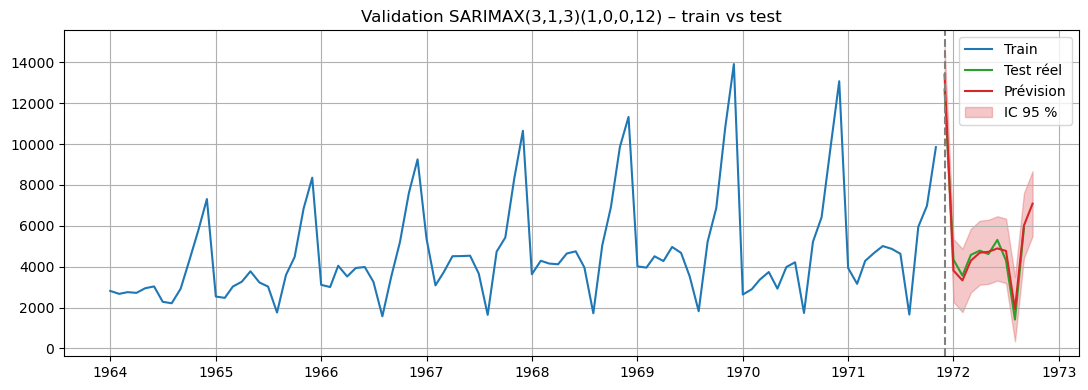

In [18]:
plt.figure(figsize=(11,4))
plt.plot(train_set, label="Train",  color="C0")
plt.plot(test_set,  label="Test réel", color="C2")
plt.plot(pred,  label="Prévision", color="C3")
plt.fill_between(IC .index, IC.iloc[:,0], IC.iloc[:,1],
                 color="C3", alpha=.25, label="IC 95 %")
plt.axvline(test_set.index[0], color="grey", ls="--")
plt.title("Validation SARIMAX(3,1,3)(1,0,0,12) – train vs test")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

In [19]:
model = SARIMAX(train_set, order = (1,1,1), seasonal_order=(1,1,0,12)).fit()
fct = model.get_forecast(steps = 48)
prediction = fct.predicted_mean

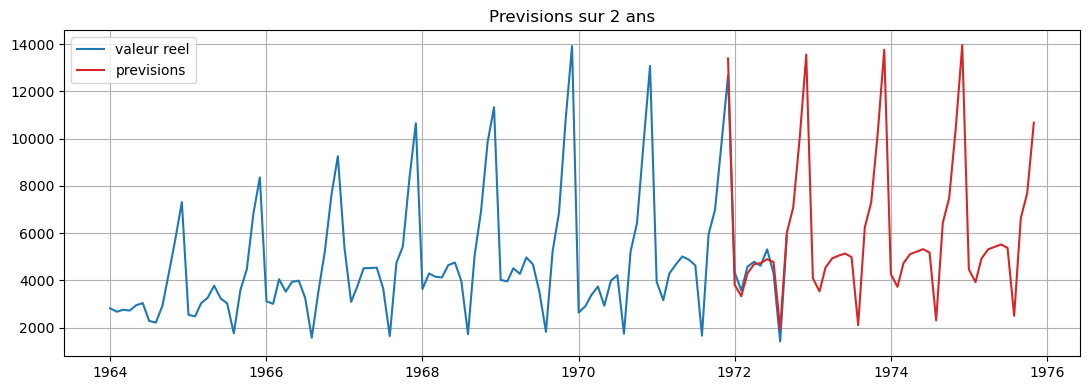

In [20]:
plt.figure(figsize=(11,4))
plt.plot(data, label = "valeur reel", color = "C0")
plt.plot(prediction, label ="previsions", color = "C3")
plt.grid(True)
plt.legend()
plt.title("Previsions sur 2 ans")
plt.tight_layout()
plt.show()